In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.ndimage import gaussian_filter1d

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    
    return(X_full, X, lag)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def bin_time_series(array, binsize, gaussian=False, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def jitter(spike):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-5,5)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

In [3]:
mat = scipy.io.loadmat('/Users/bengieru/Downloads/mouse_1005_session_1_baseline_raw_trace.mat')

path = '/Users/bengieru/Downloads/'
subject = 'm_1005_session_1_baseline'

trace=open( path + subject + "_trace.csv", "r")
spike=open( path + subject + "_spikes_complexity.csv", "r")
dff=open( path + subject + "_dff.csv", "r")

reader_trace = csv.reader(trace)
reader_spike = csv.reader(spike)
reader_dff = csv.reader(dff)

n = 134

traces = np.zeros((n,8000)) # roi x time
spikes = np.zeros((n,8000)) # roi x time
dff = np.zeros((n,8000)) # roi x time
#row_count = sum(1 for row in reader)
    
for i,line in enumerate(reader_trace):
    for j in range(len(line)):
        traces[i][j]=line[j]
for i,line in enumerate(reader_spike):
    for j in range(len(line)):
        spikes[i][j]=line[j]
for i,line in enumerate(reader_dff):
    for j in range(len(line)):
        dff[i][j]=line[j]

In [4]:
#mat['trace'], dff, traces, spikes

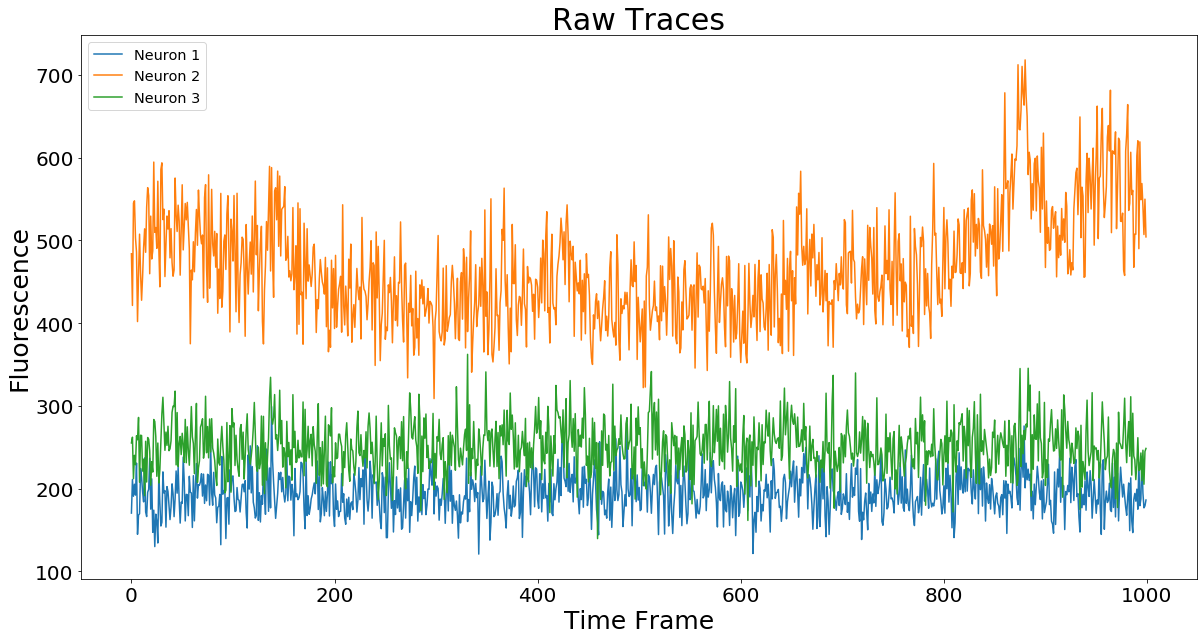

In [5]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
neurons = 3
for i in range(neurons):
    ax.plot(mat['trace'][i][:1000], label = 'Neuron %d'%(i+1))
ax.set_title('Raw Traces', fontsize = 30)
ax.set_ylabel('Fluorescence', fontsize = 25)
ax.set_xlabel('Time Frame', fontsize =25)
plt.tick_params('both', labelsize= 20)
ax.legend(fontsize = 'x-large')
ax.set_xticks([0,200,400,600,800,1000])
plt.savefig('/Users/bengieru/Desktop/mln_v0/raw_trace.pdf')

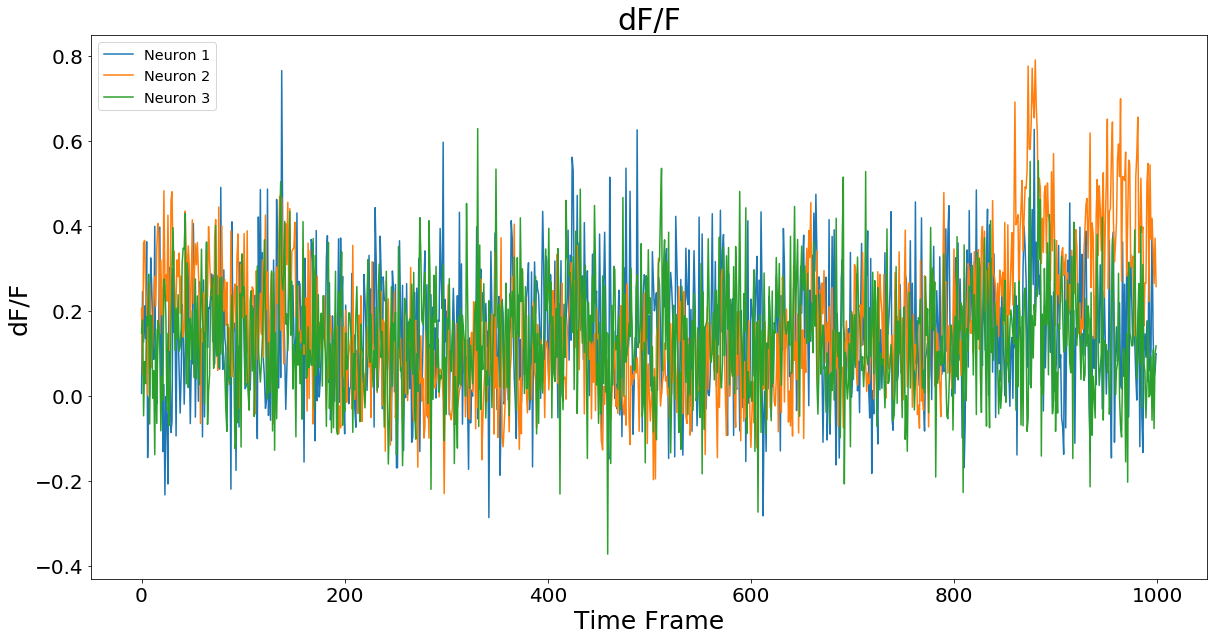

In [6]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
neurons = 3
for i in range(neurons):
    ax.plot(dff[i][:1000], label = 'Neuron %d'%(i+1))
ax.set_title('dF/F', fontsize = 30)
ax.set_ylabel('dF/F', fontsize = 25)
ax.set_xlabel('Time Frame', fontsize =25)
plt.tick_params('both', labelsize= 20)
ax.legend(fontsize = 'x-large')
ax.set_xticks([0,200,400,600,800,1000])
plt.savefig('/Users/bengieru/Desktop/mln_v0/dfF.pdf')

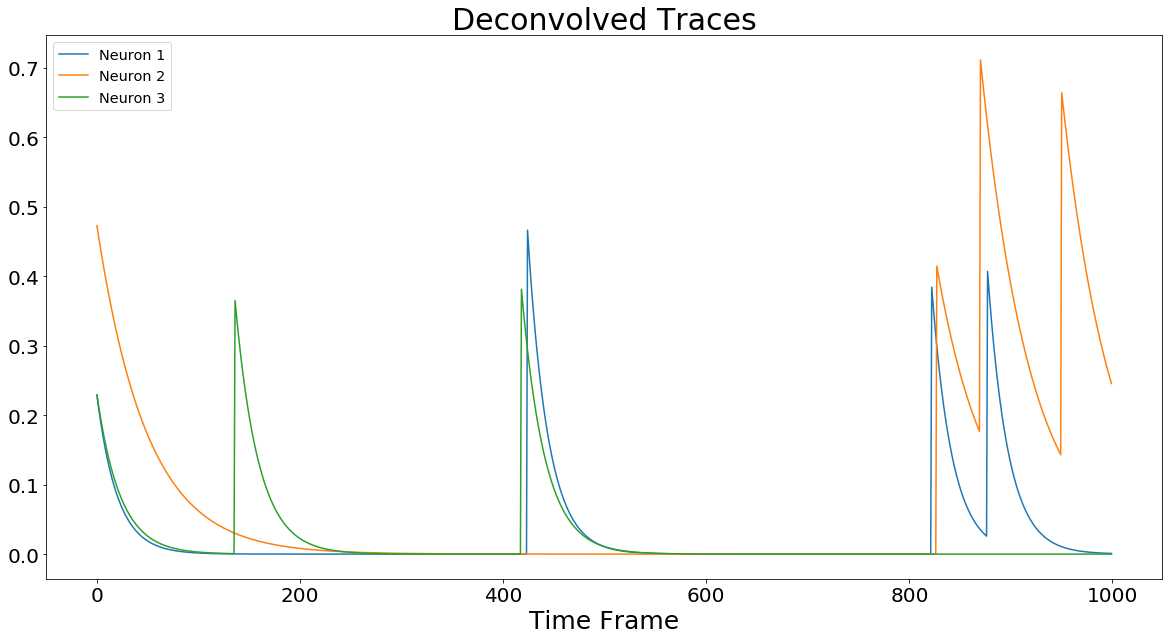

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
neurons = 3
for i in range(neurons):
    ax.plot(traces[i][:1000], label = 'Neuron %d'%(i+1))
ax.set_title('Deconvolved Traces', fontsize = 30)
#ax.set_ylabel('Clean Calcium', fontsize = 25)
ax.set_xlabel('Time Frame', fontsize = 25)
plt.tick_params('both', labelsize = 20)
ax.legend(fontsize = 'x-large')
ax.set_xticks([0,200,400,600,800,1000])
plt.savefig('/Users/bengieru/Desktop/mln_v0/clean_trace.pdf')

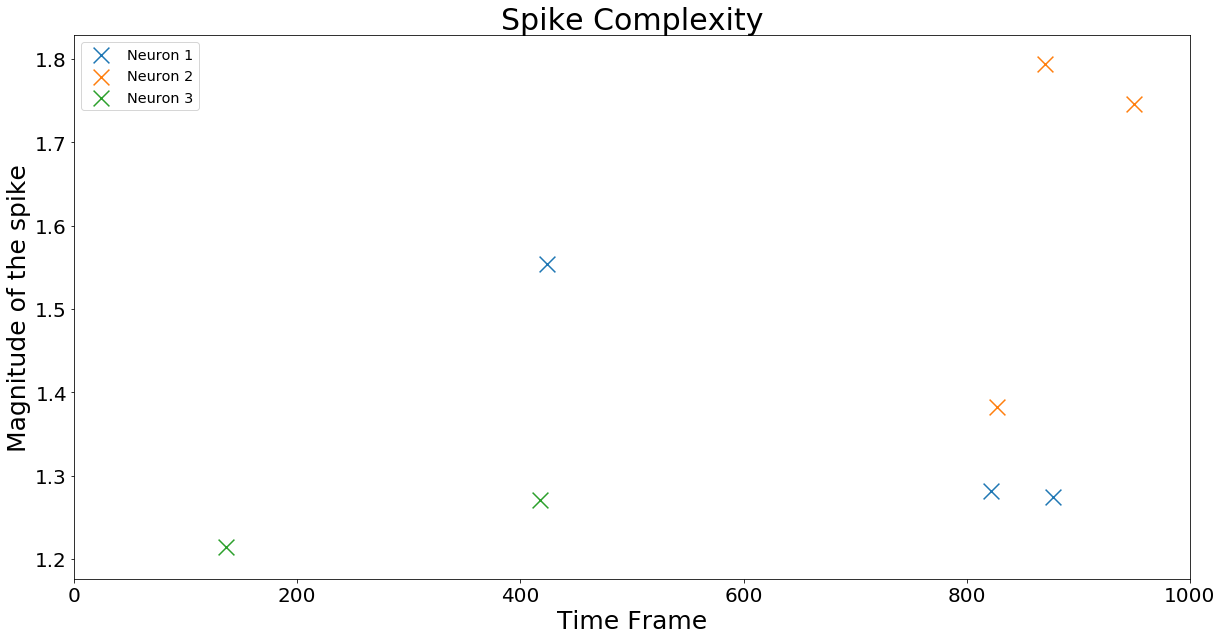

In [8]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
neurons = 3
for i in range(neurons):
    ax.scatter(np.nonzero(spikes[i][:1000])[0],[spikes[i][np.nonzero(spikes[i][:1000])[0][j]] for j in range(len(np.nonzero(spikes[i][:1000])[0]))],  marker = 'x', s = 250, label = 'Neuron %d'%(i+1))
ax.set_title('Spike Complexity', fontsize = 30)
ax.set_ylabel('Magnitude of the spike', fontsize = 25)
ax.set_xlabel('Time Frame', fontsize =25)
ax.set_xticks([0,200,400,600,800,1000])
plt.tick_params('both', labelsize= 20)
ax.legend(fontsize = 'x-large')
plt.savefig('/Users/bengieru/Desktop/mln_v0/spike_complexi.pdf')

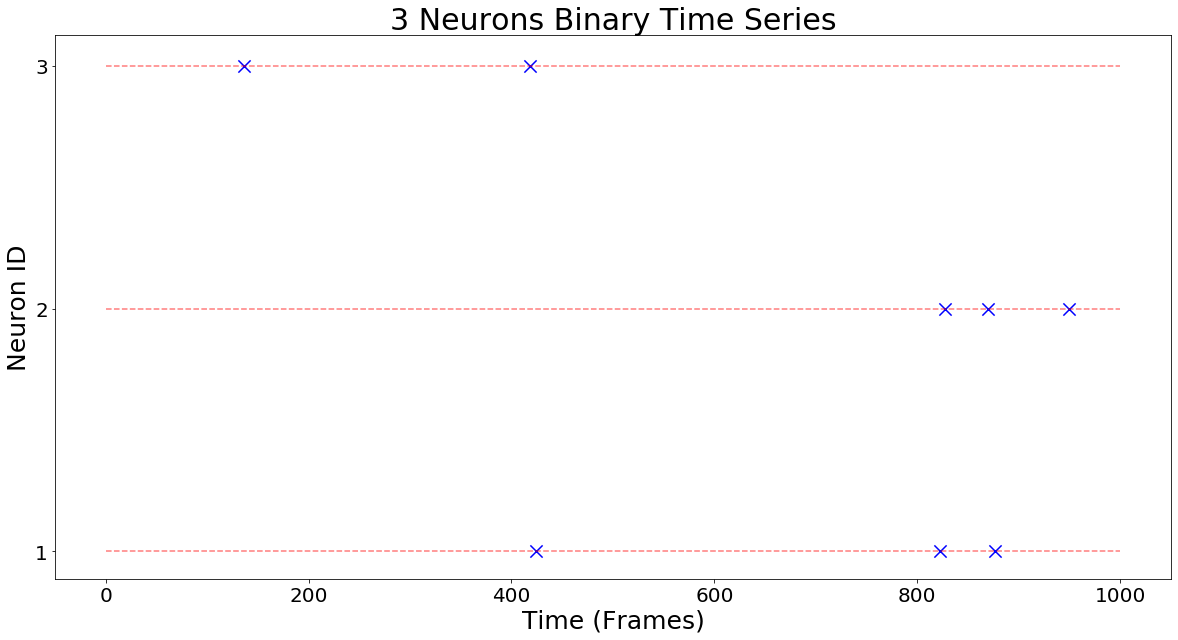

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
y = np.arange(1,neurons+1)
for i in range(neurons):
    ax.scatter(np.nonzero(spikes[i][:1000])[0], np.linspace(i+1,i+1,len(np.nonzero(spikes[i][:1000])[0])) , c = 'b', marker = 'x', s = 150)
    ax.hlines(y,0, 1000, linestyle = '--', alpha =0.2, color = 'r')
ax.set_yticks([1,2,3])
ax.set_title('3 Neurons Binary Time Series', fontsize = 30)
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 25)
ax.tick_params(axis = 'both', labelsize =20)
plt.savefig('/Users/bengieru/Desktop/mln_v0/time_series.pdf')

In [10]:
adjacency_matrice = cross_correlation_matrix(spikes[:3][:1000])[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


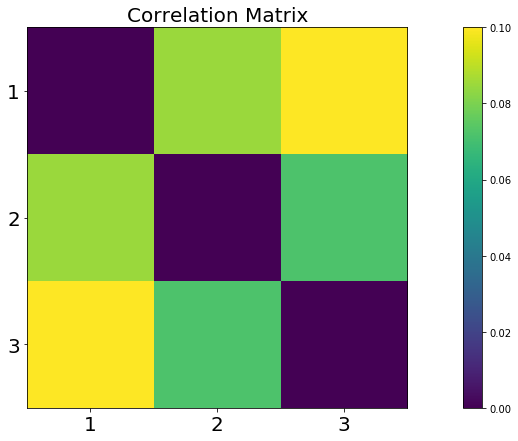

In [59]:
fig,ax = plt.subplots(1,1,figsize=(20,7))
k = ax.imshow(adjacency_matrice, extent = [0.5,3.5,3.5,0.5])
ax.set_title('Correlation Matrix',fontsize=20)
ax.set_xticks([1,2,3])
ax.set_yticks([3,2,1])
ax.tick_params(axis = 'both', labelsize =20)


fig.colorbar(k)
plt.savefig('/Users/bengieru/Desktop/mln_v0/corr.pdf')

In [19]:
standard_dev = 1.75
binsize = 500
binned_spikes = bin_time_series(spikes[:3,:1000], binsize, gaussian = True, sigma = standard_dev) # bin the spikes into fixed length and apply gaussian kernel of length 3

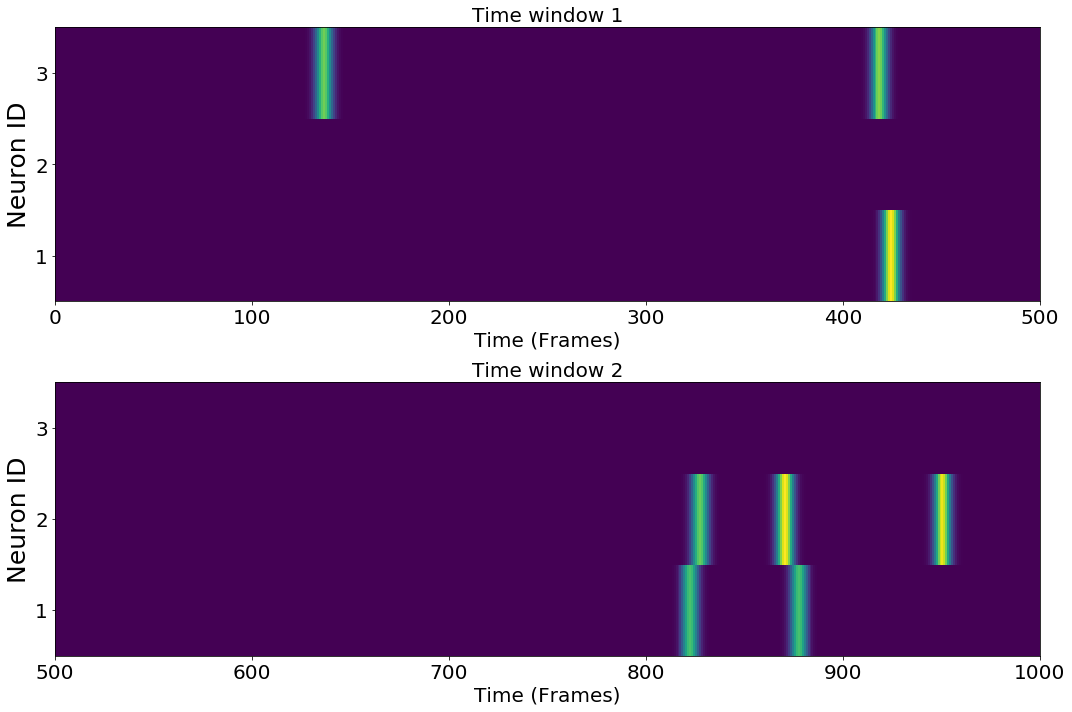

In [52]:
fig,ax = plt.subplots(2,1,figsize=(15,10))
for i in range(2):
    ax[i].imshow(binned_spikes[i], origin = 'bottom left', interpolation='nearest', aspect='auto', extent = [i*500,(i+1)*500,0.5,3.5])
    ax[i].set_title('Time window %d'%(i+1), fontsize = 20)
    ax[i].set_xticks([i*500+j*100 for j in range(6)])
    ax[i].set_yticks([1,2,3])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize =20)
plt.tight_layout()
plt.savefig('/Users/bengieru/Desktop/mln_v0/binned.pdf')

In [22]:
adjacency_matrices = []
for i in range(2):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


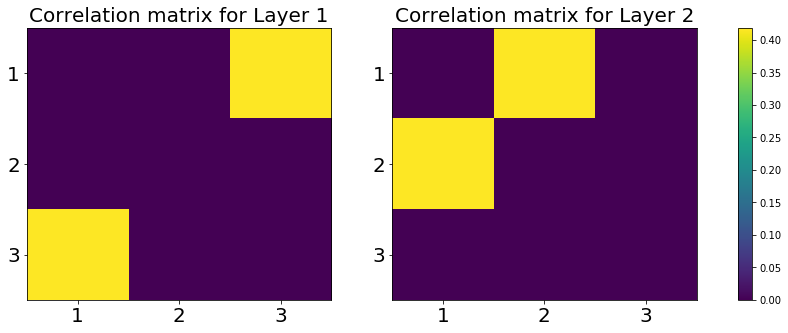

In [58]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    n = ax[i].imshow(adjacency_matrices[i], interpolation='nearest', aspect='auto',extent = [0.5,3.5,3.5,0.5])
    ax[i].set_title('Correlation matrix for Layer %d'%(i +1),fontsize=20)
    ax[i].set_xticks([1,2,3])
    ax[i].set_yticks([3,2,1])
    ax[i].tick_params(axis = 'both', labelsize =20)
fig.colorbar(n, ax=ax.ravel().tolist())
plt.savefig('/Users/bengieru/Desktop/mln_v0/adjacency_layr.pdf')